### Spontaneously polarised films of MeOH
_Authors: Andrew Cassidy (1), Alfred Hopkinson (1), Marta Podgorny (2), Anita Dawes (2), David Field (1,3)_

1. [Center for Interstellar Catalysis, Department of Physics and Astronomy, Aarhus University, DK](https://www.phys.au.dk/intercat)
2. [Open University](https://kdvi.uva.nl/)
3. [Department of Physics and Astronomy, Aarhus University, DK](https://www.phys.au.dk)

### Structure
Data were recorded as text files. There are two text files for each spectrum because each scan was performed twice. This is to allow averaging and remove noise. The following code will find the text file for a given dose at a given temperuture, and using the corresponding background file, produce a plot of absorbance

[Eqn. 1]<a class="anchor" id="equation_1"></a>
\begin{align}
\mathrm{(1)} \quad Abs = log_{10}\frac{I_{0}(\lambda)}{I(\lambda)}
\end{align}
where $I_{0}(\lambda)$ is the intensity of light transmitted at $\lambda$ through the background sample and $I(\lambda)$ is the intensity transmitted through the sample.

Once the absorbance is generated for a given experiment, we then fit that absorabnce curve, as a funciton of $\lambda$ with 3 Gaussian peaks, to find the peak positions in the spectrum.


#### Lists of dictionaries and dataframes

There are several databases and dictionaries generated below to store the data:

- df = dataframe for each individual experiment, *i.e.*, each a given sample depoition at a given substrate temperature
headers are: wavelength,absorbance,absorbance_bk,residual_3gauss,_3Gauss_fit,gauss_peak_1,gauss_peak_2,gauss_peak_3,residuals_sum
Each df is saved as a csv file with file name gien by depositoin numbers and substrate temperature.
          
- data_dict = dictionary for all peak positions as determined by Guassian fits; 
keys - data_dict[temperatures][deposition][Gauss][amplitude,position,width,amp_err,position_err,width_err]\n

- all_abs_peak_positions = dictionary for aligning G2 peak position with corresponding absorption value;
keys - all_abs_peak_positions[temperature][peak_absorbances][Gauss_2_pos]

In [1]:

from IPython.display import Image
from IPython.display import HTML, Markdown
import math
import numpy, pandas 
import matplotlib.pyplot as plt
import openpyxl
import xlrd
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import os
from scipy import __version__
from os.path import join
from os import listdir
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
import scipy.constants as constants
from sys import float_info

print('finished import')




finished import


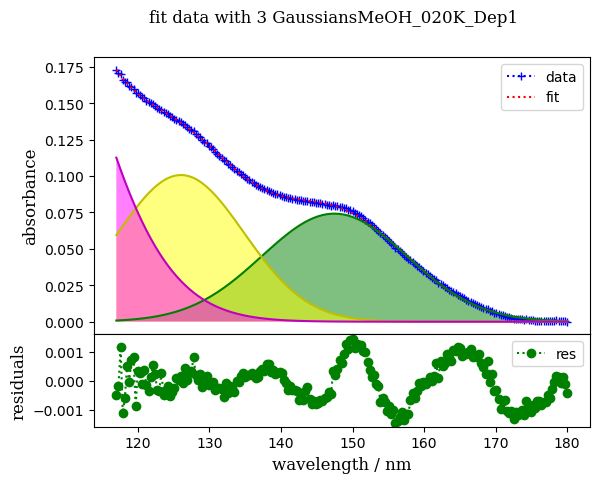

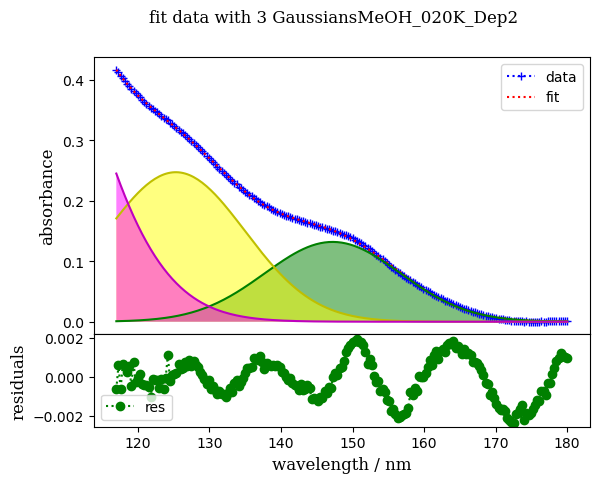

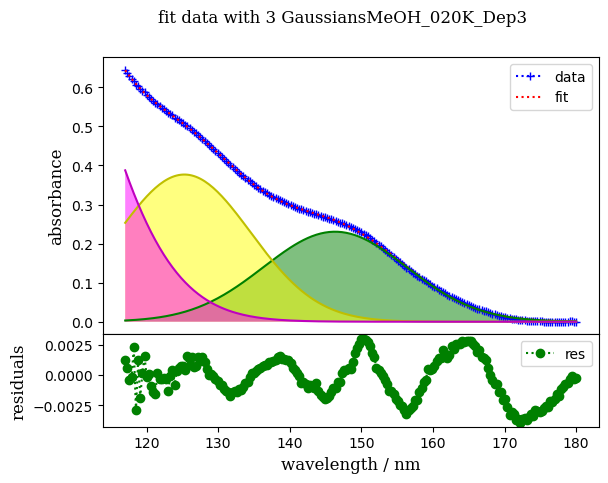

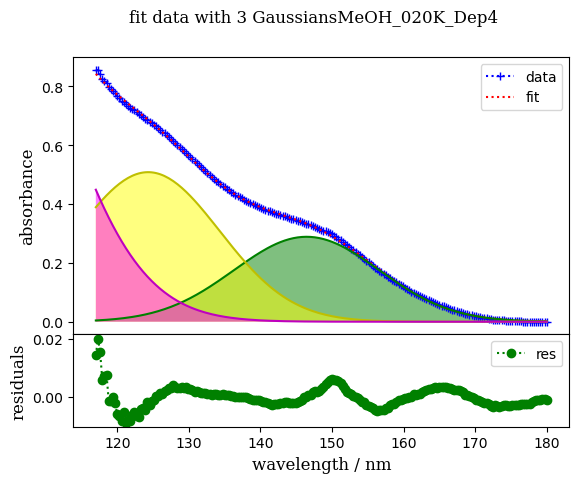

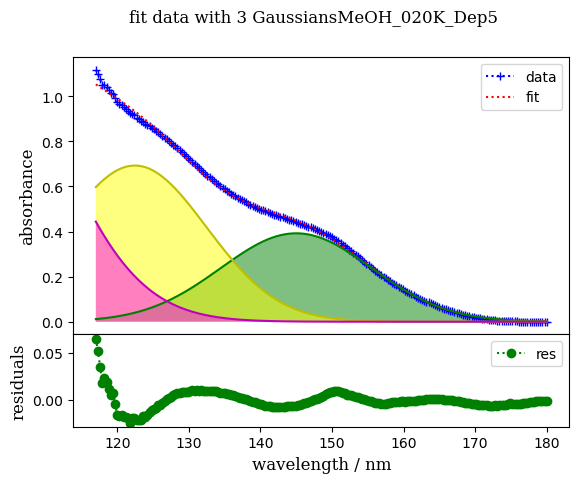

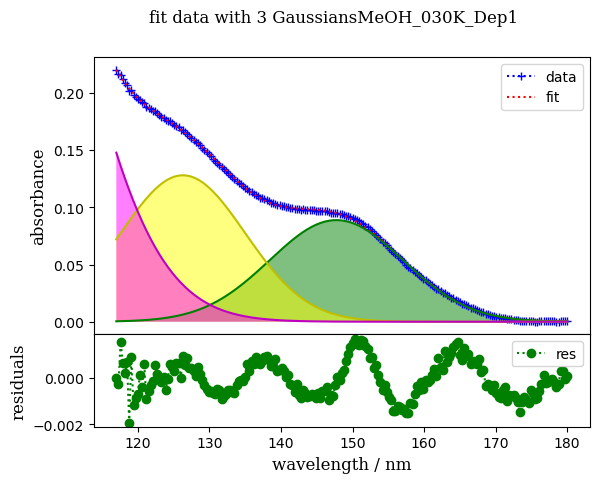

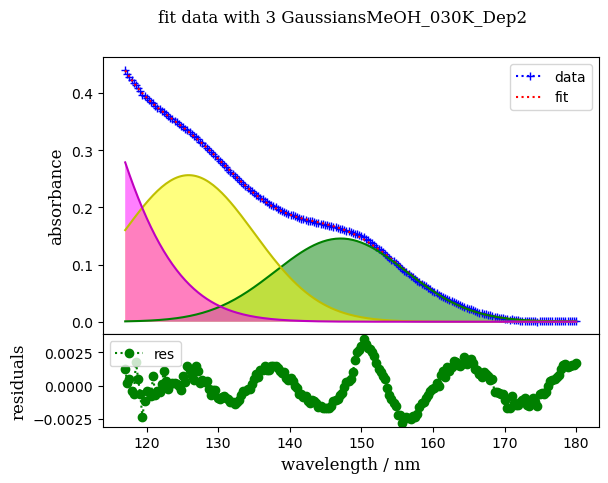

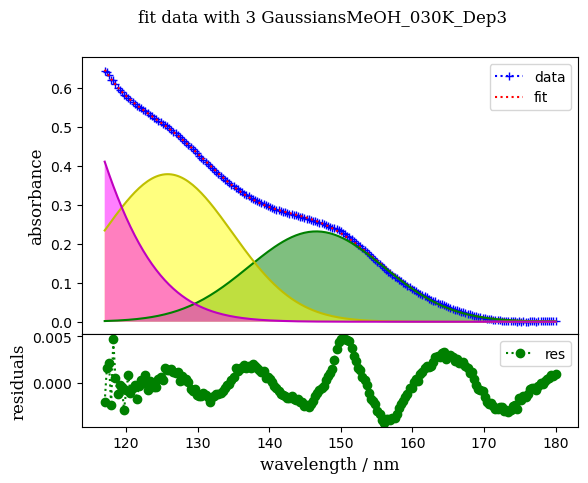

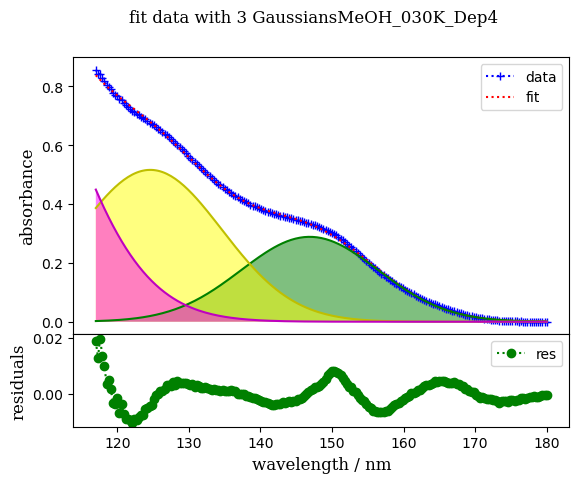

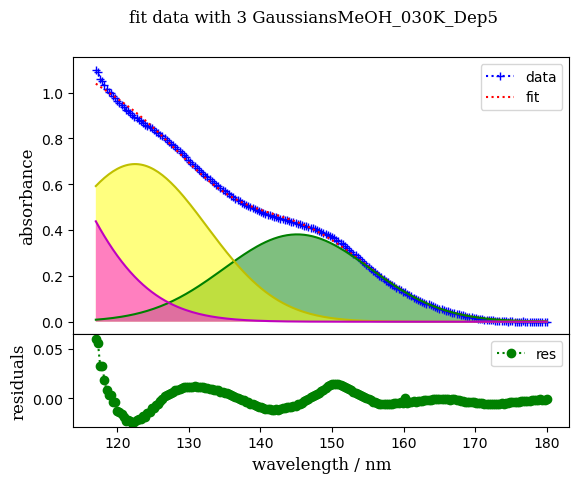

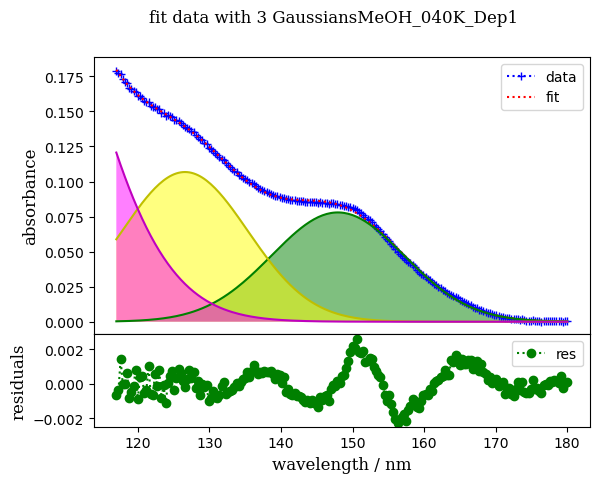

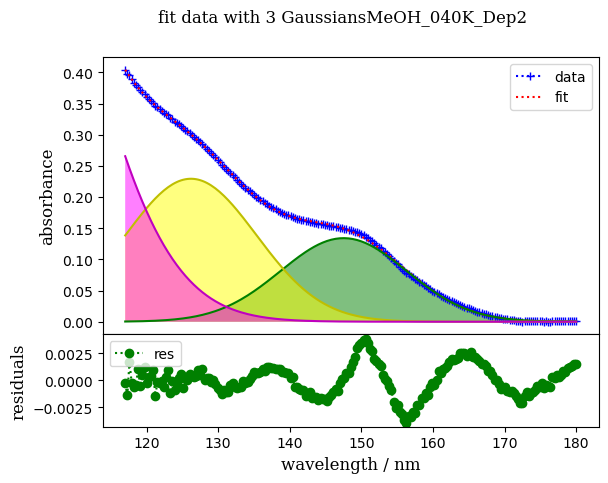

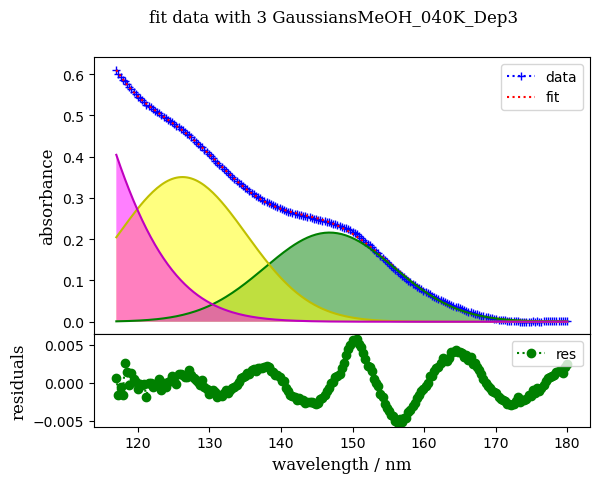

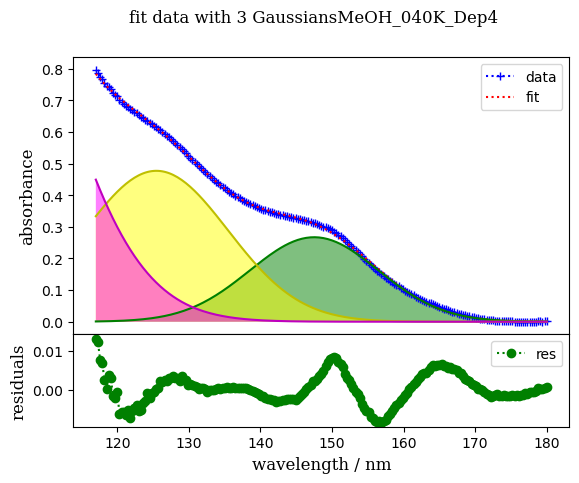

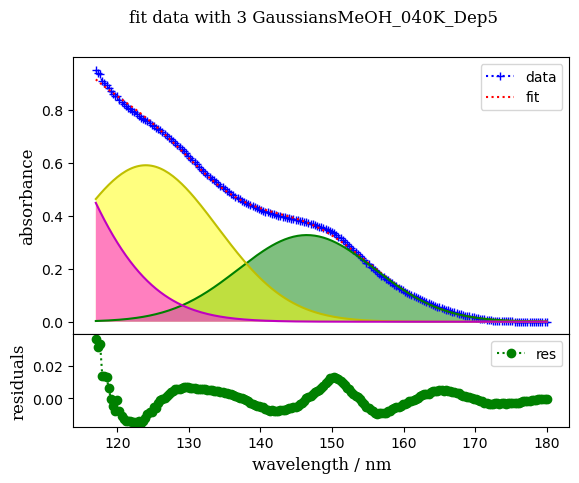

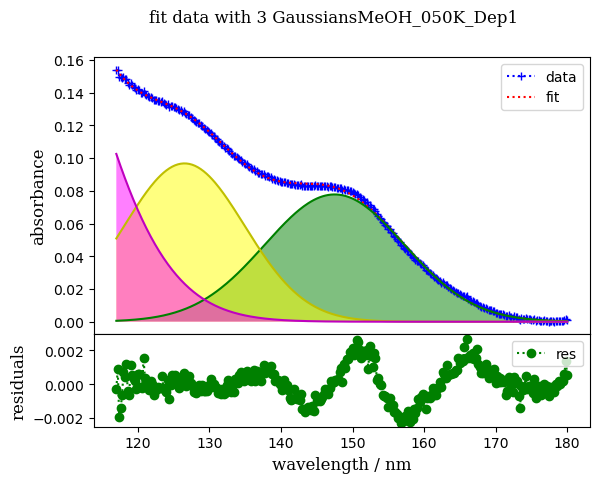

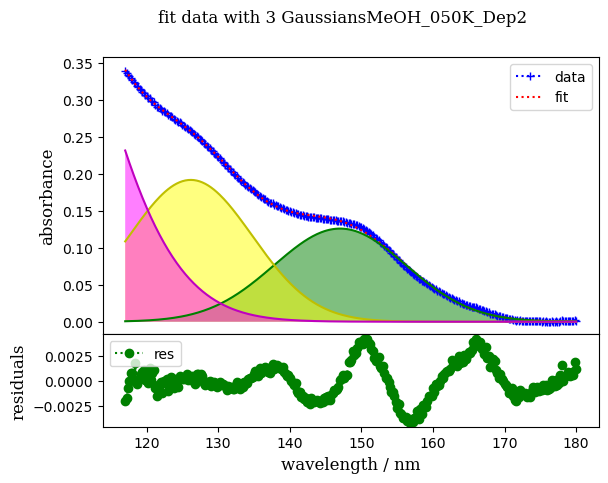

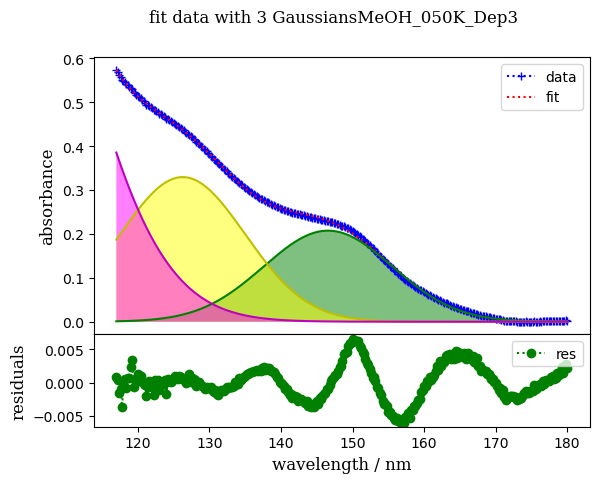

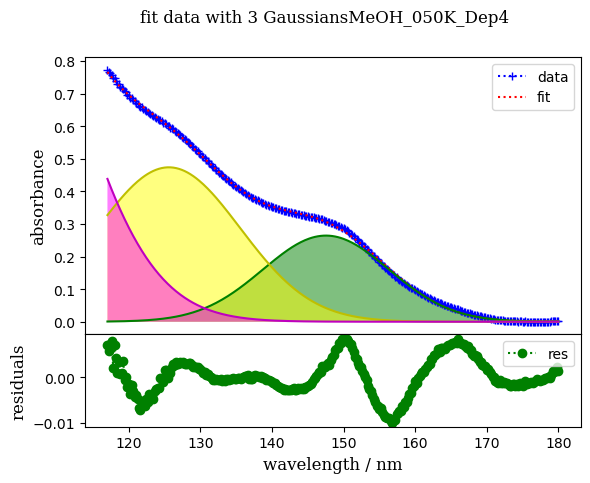

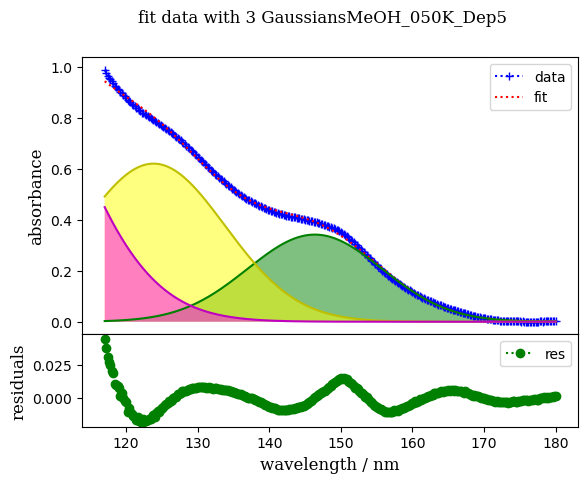

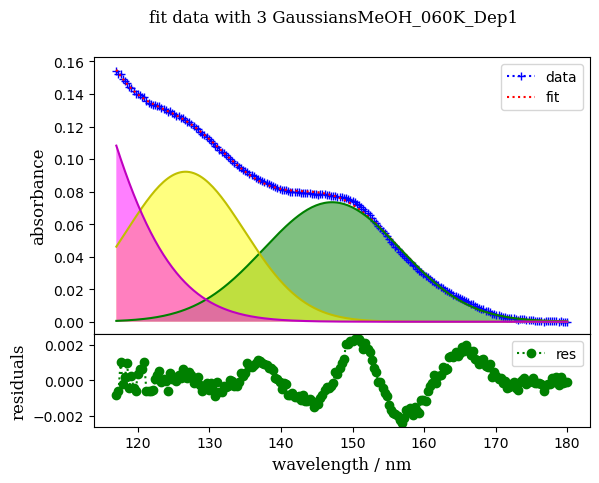

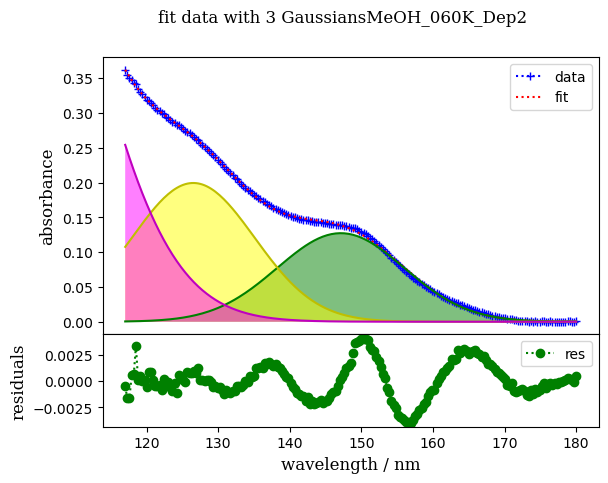

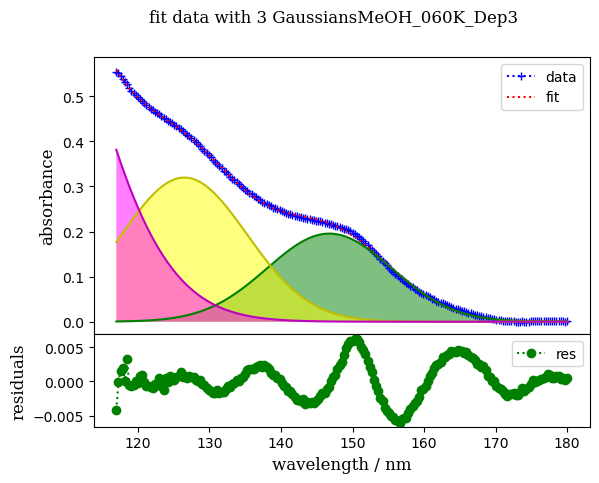

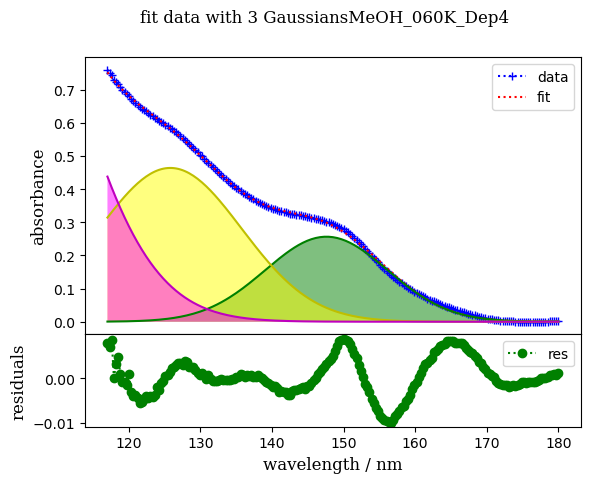

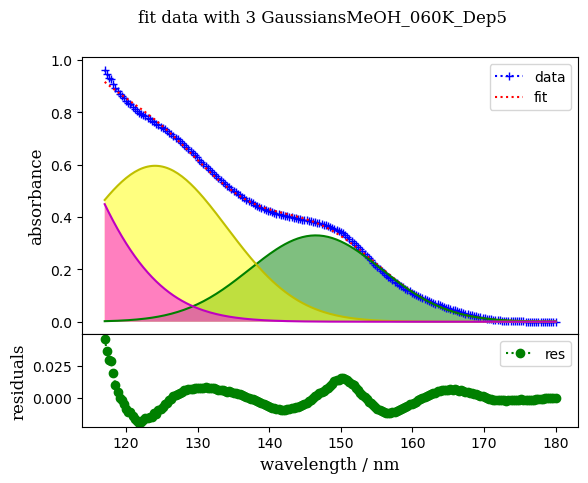

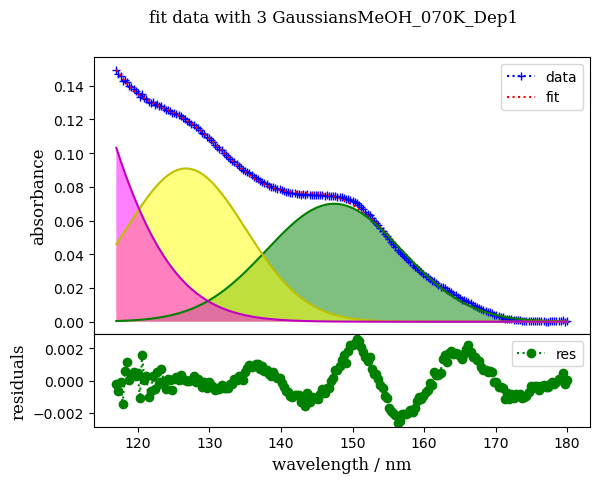

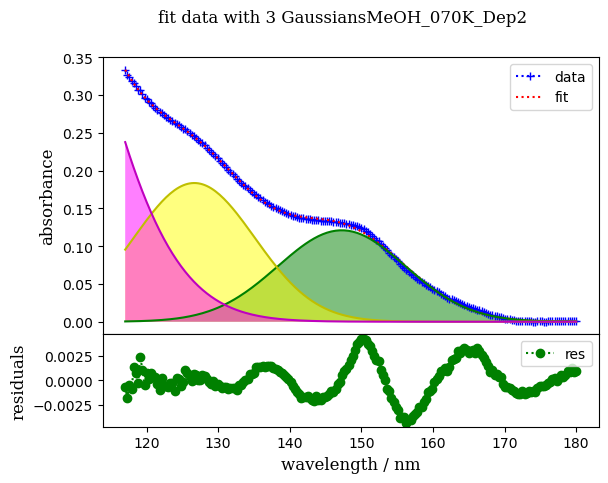

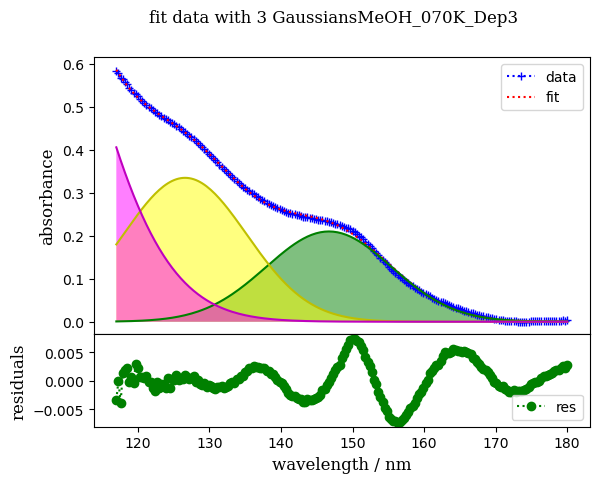

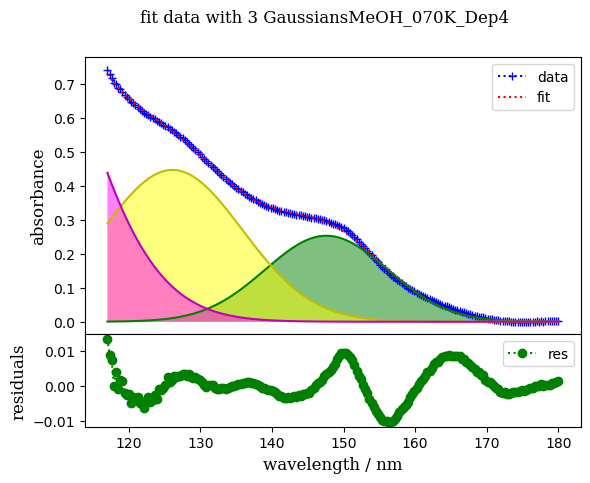

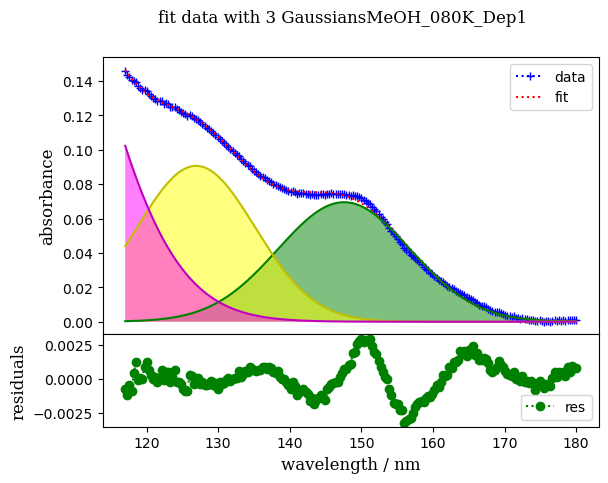

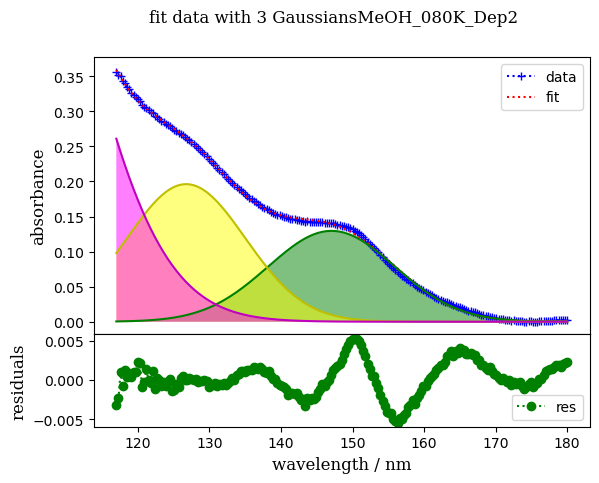

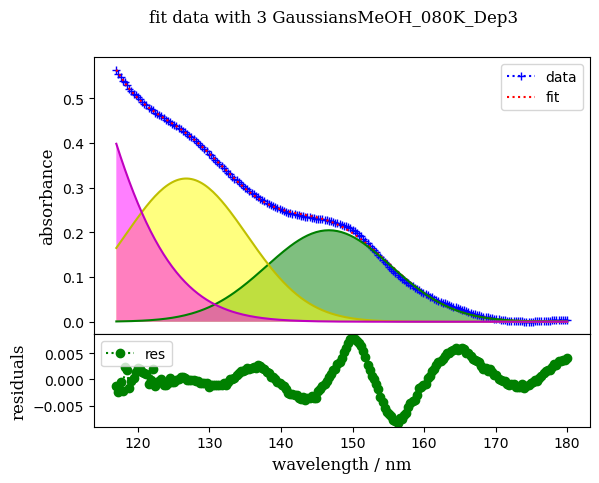

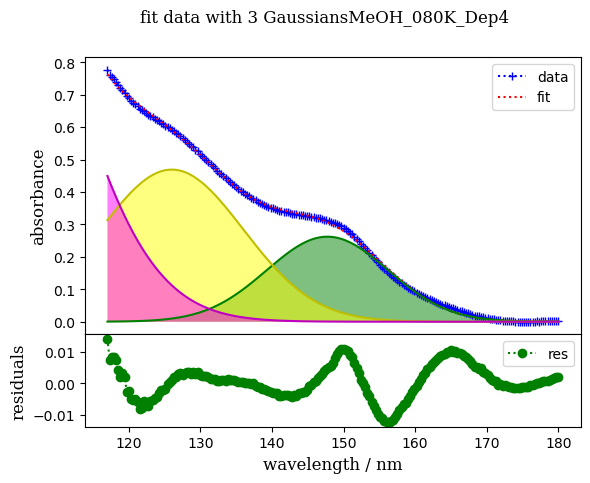

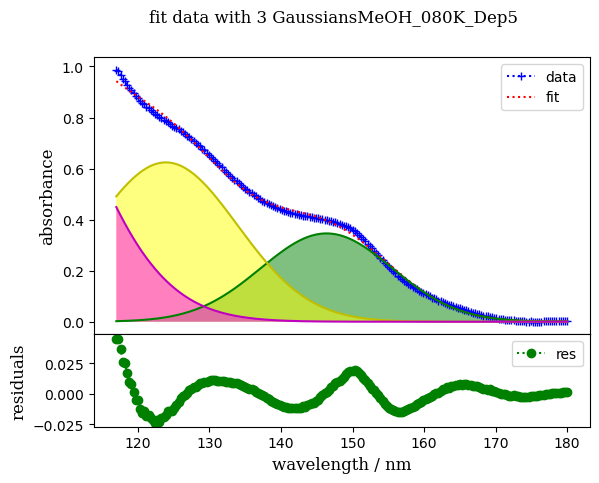

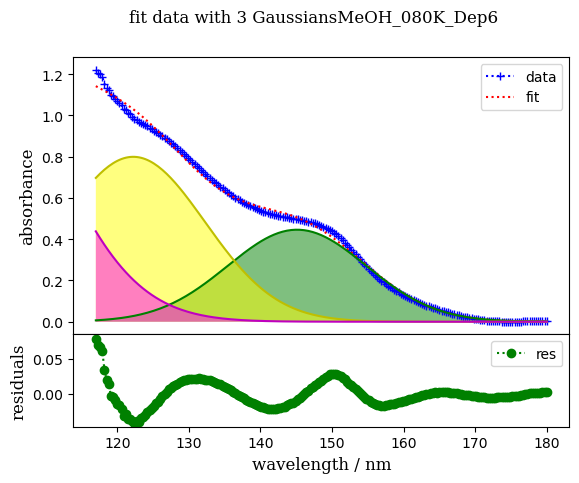

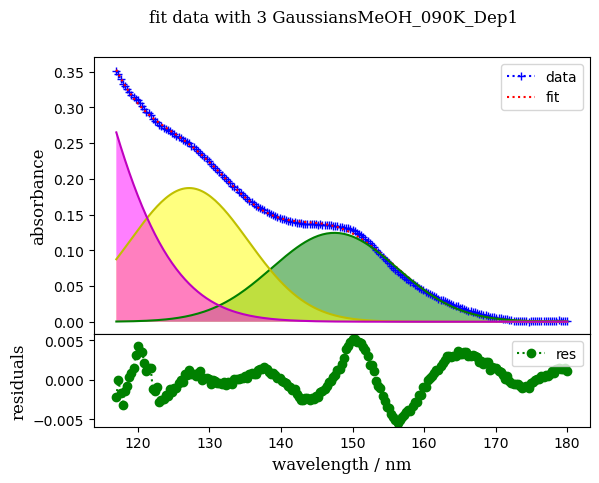

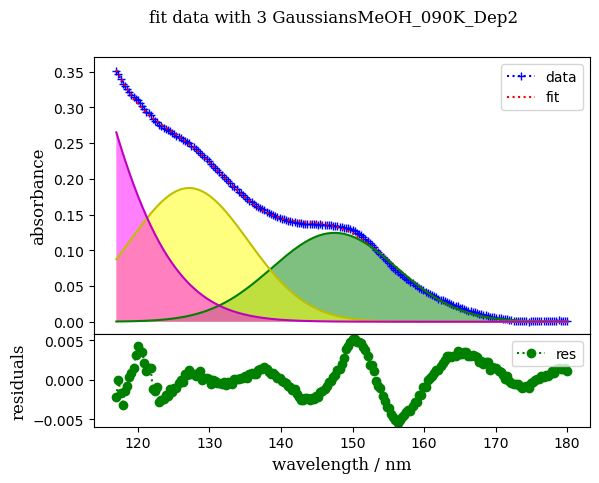

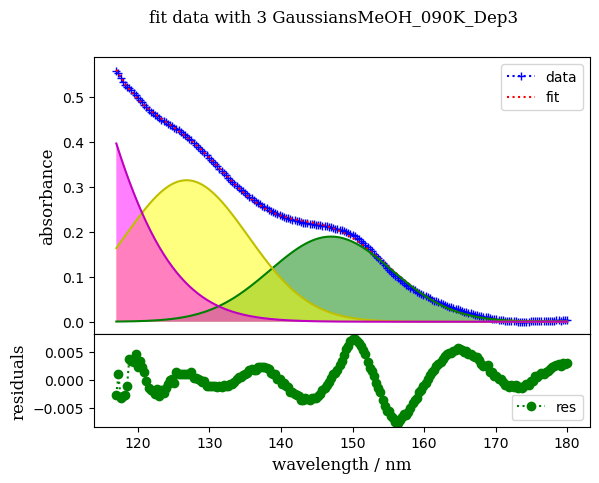

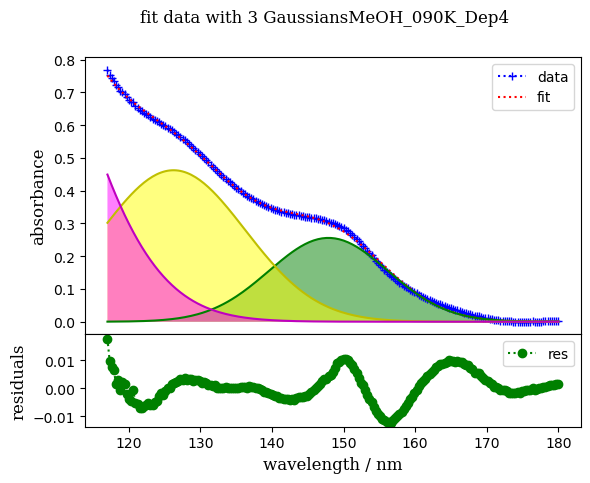

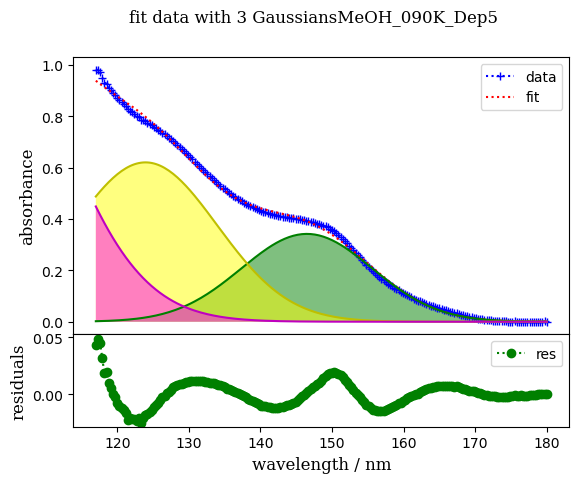

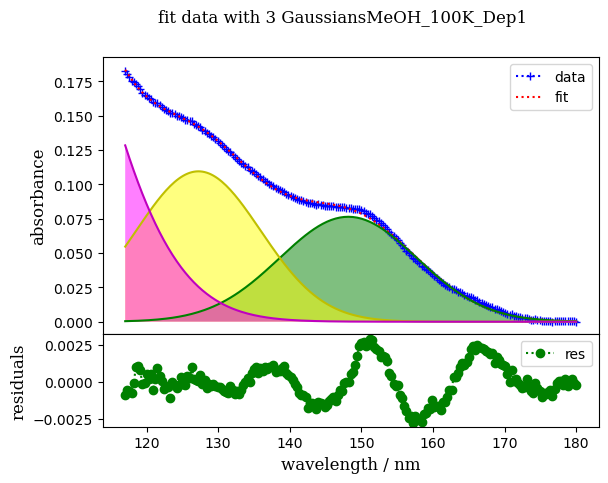

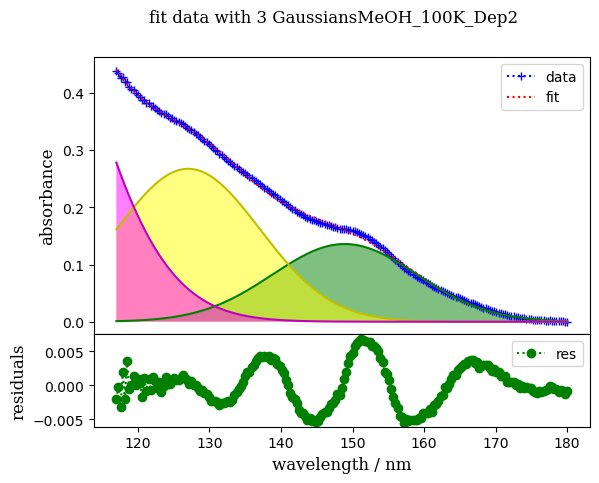

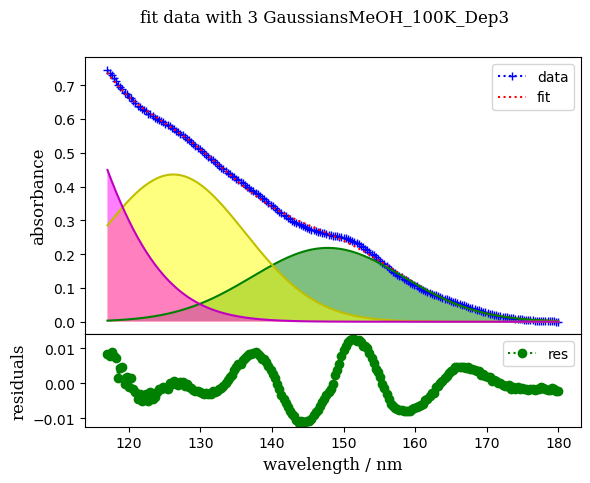

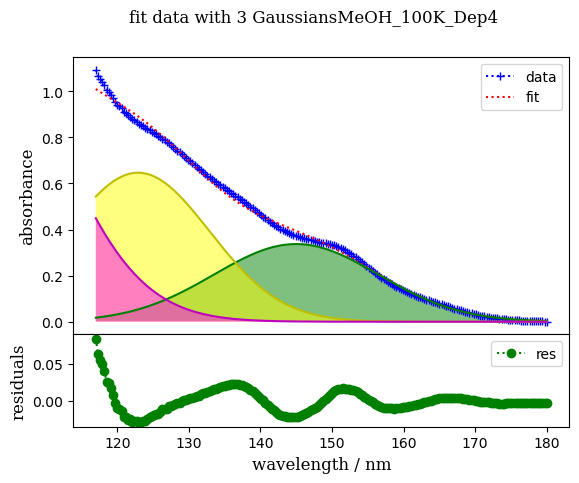

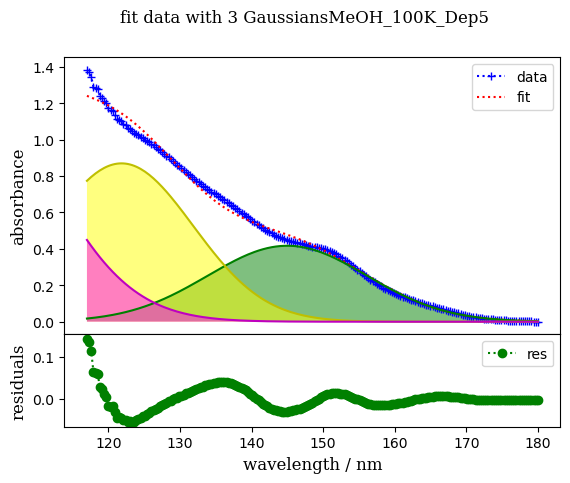

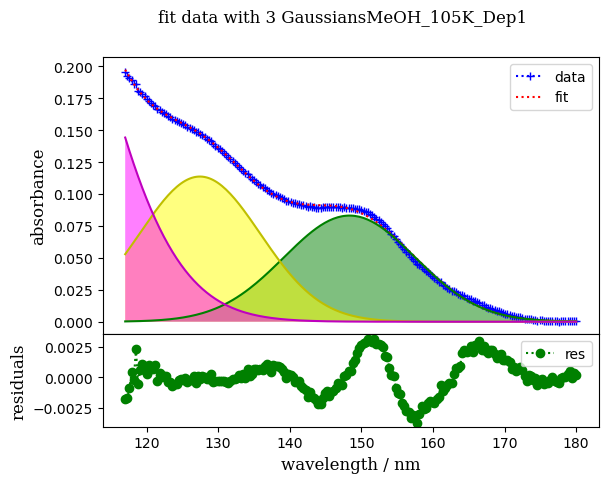

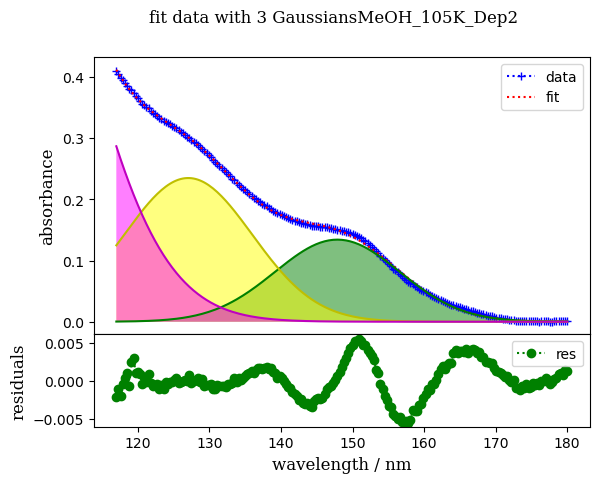

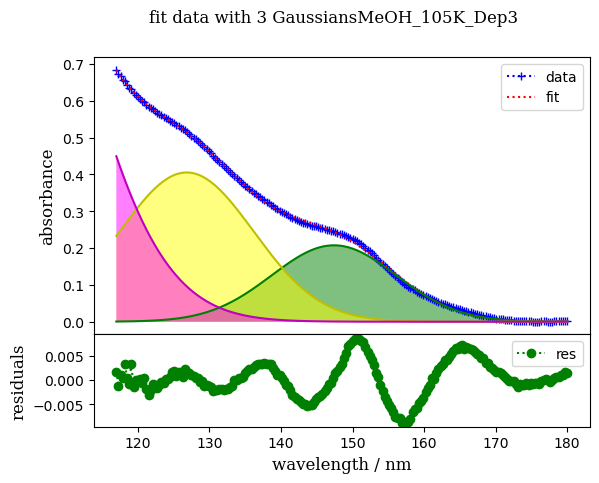

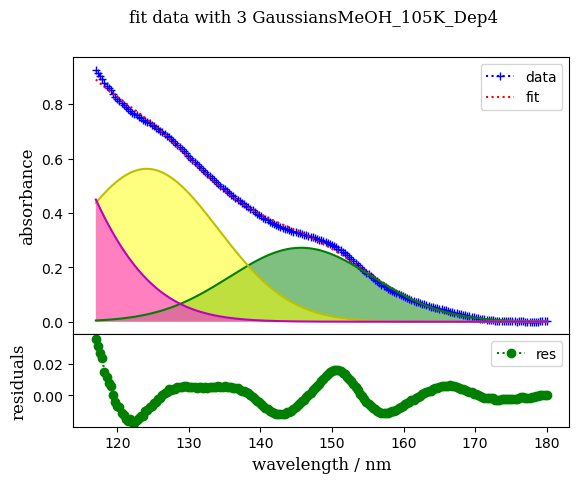

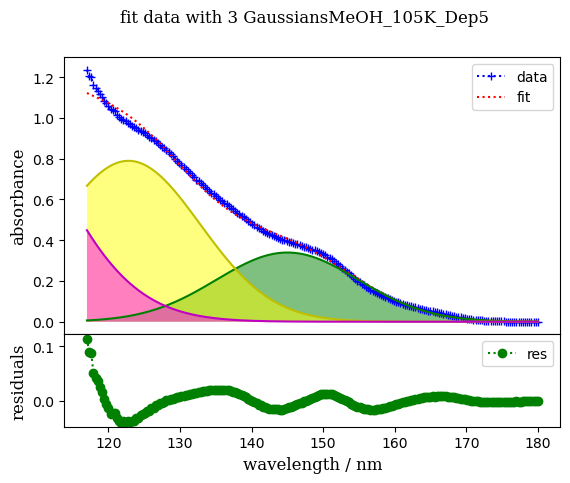

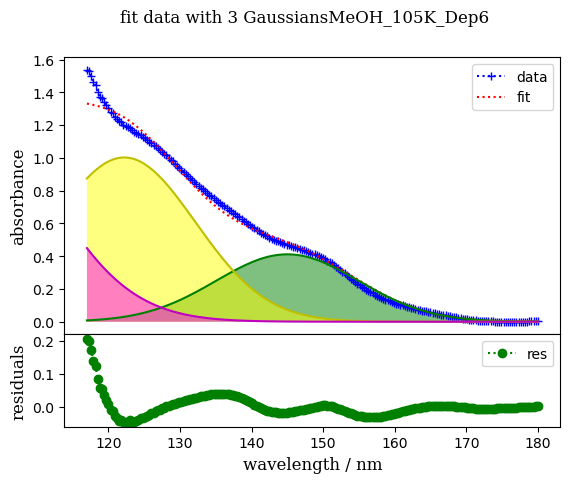

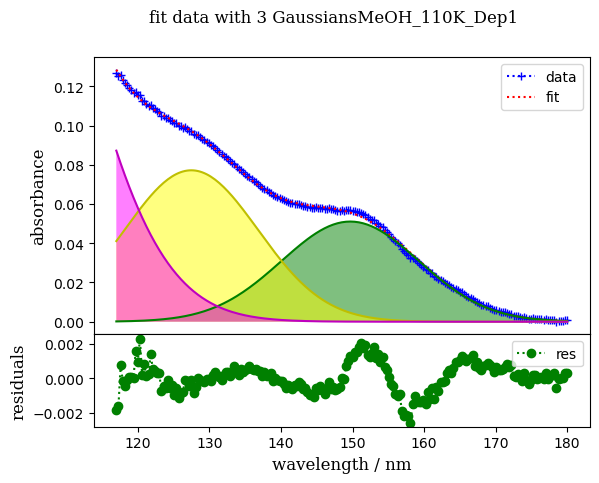

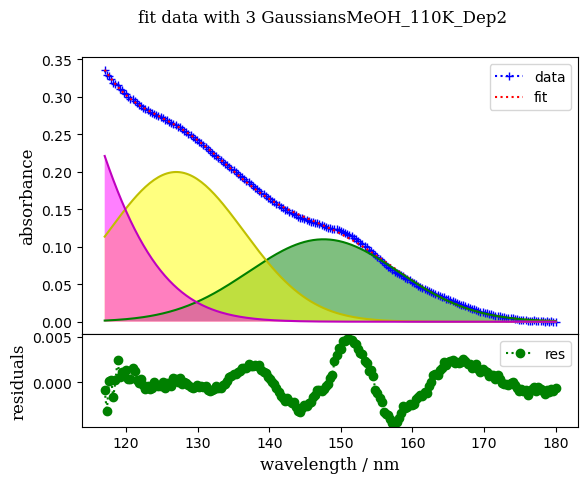

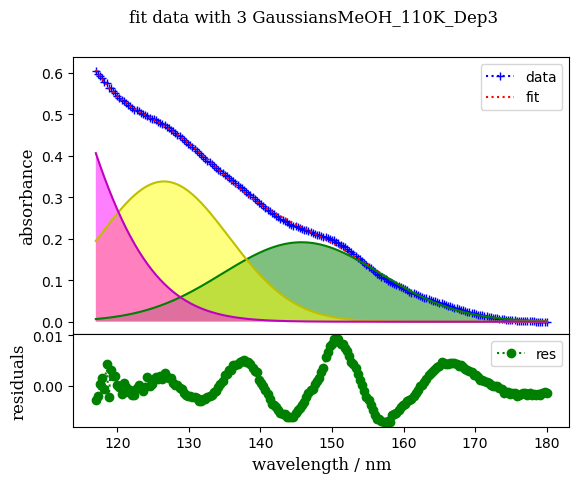

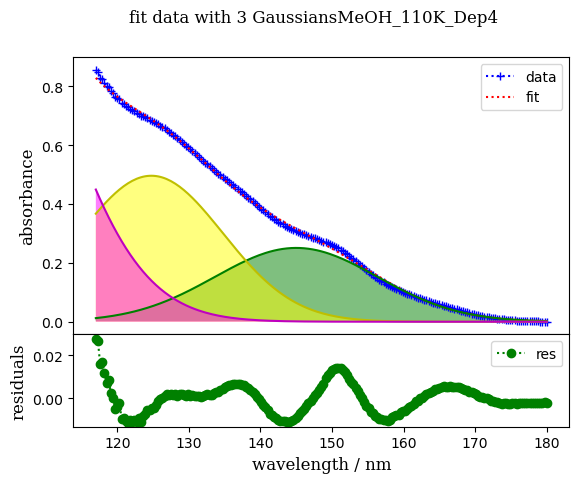

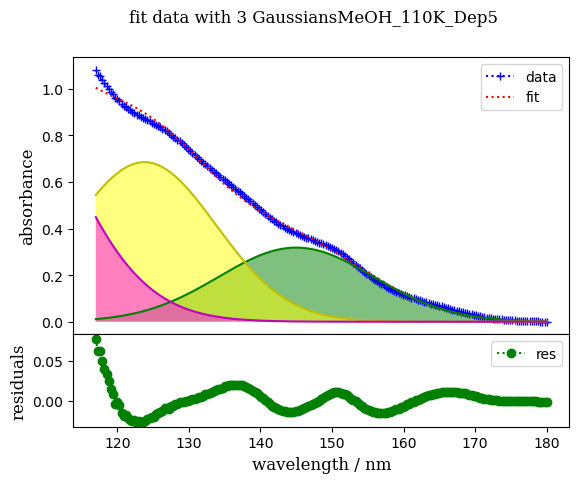

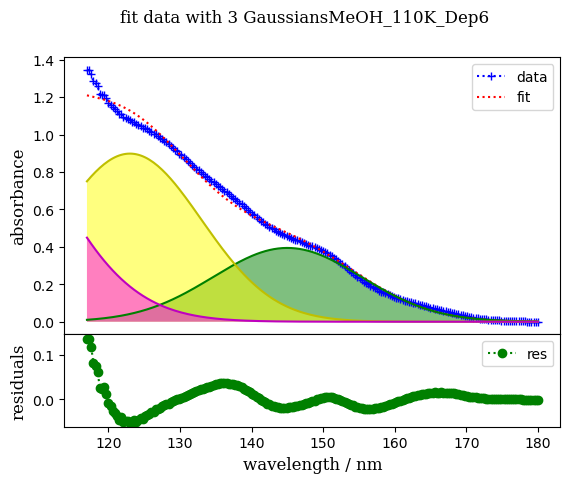

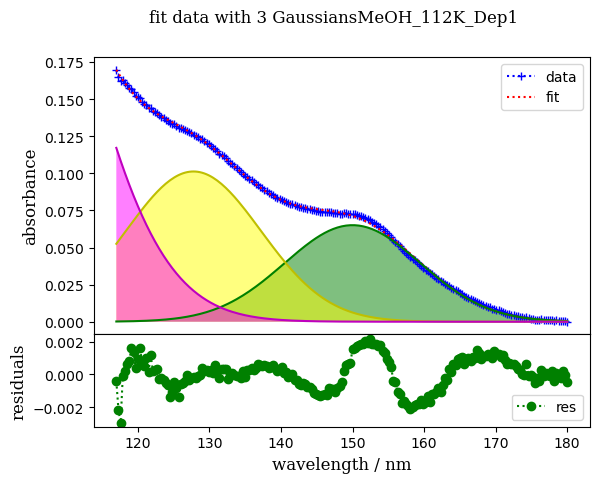

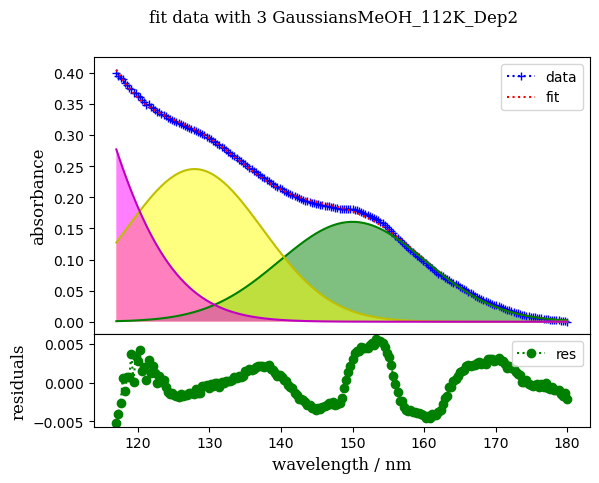

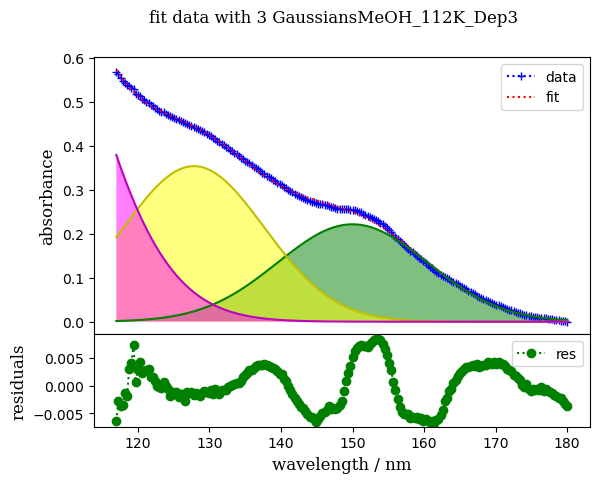

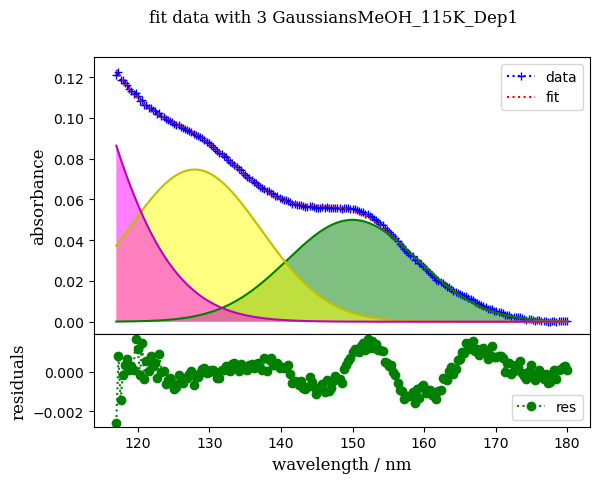

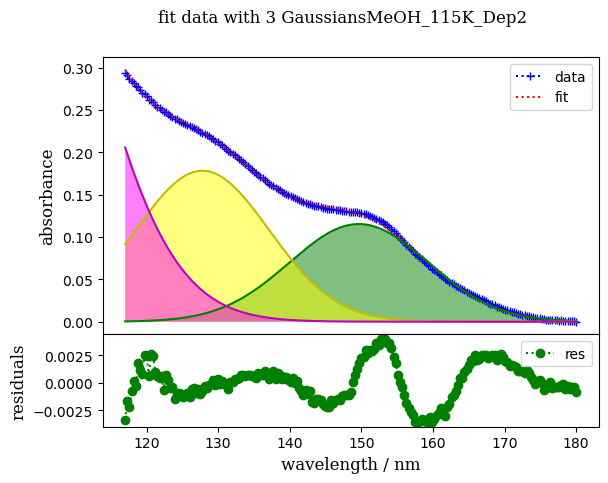

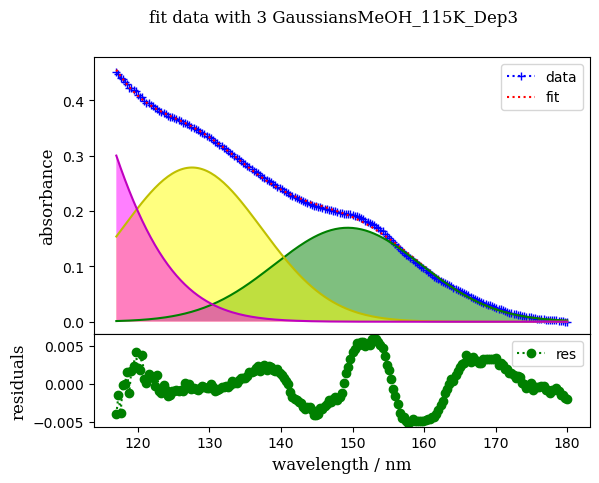

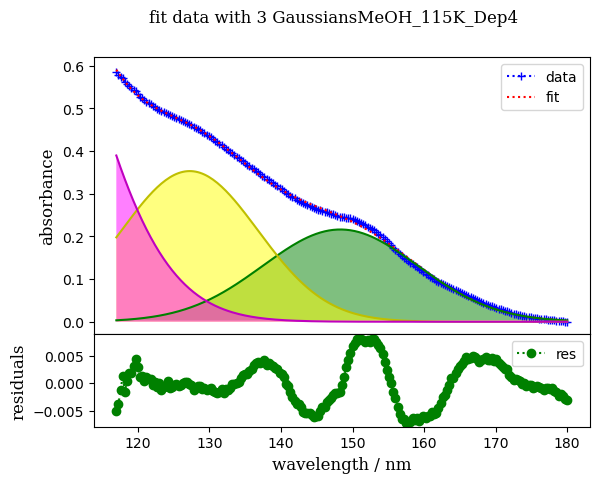

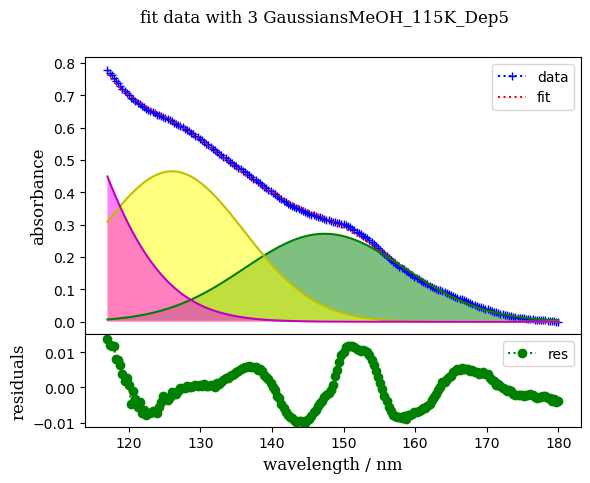

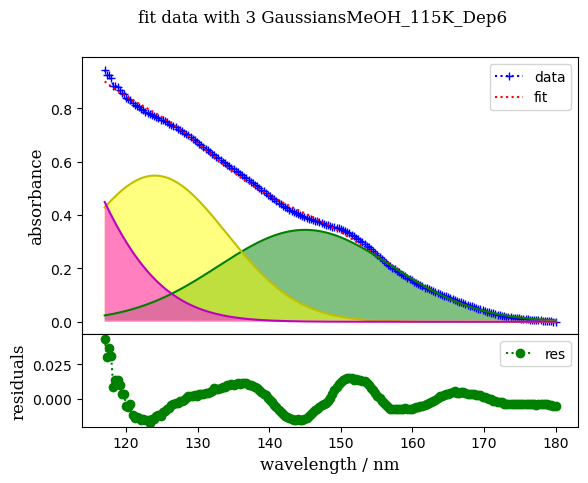

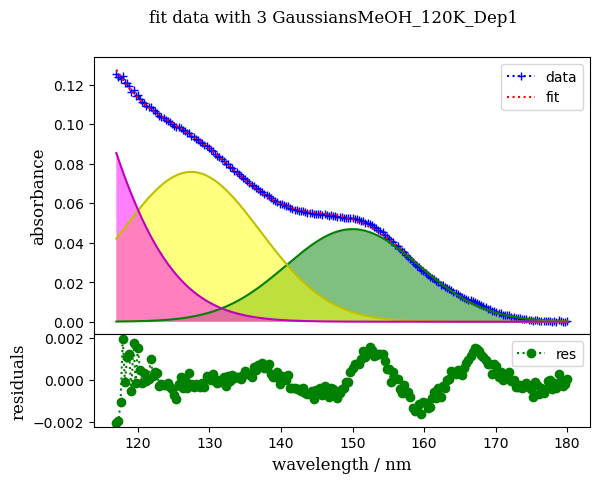

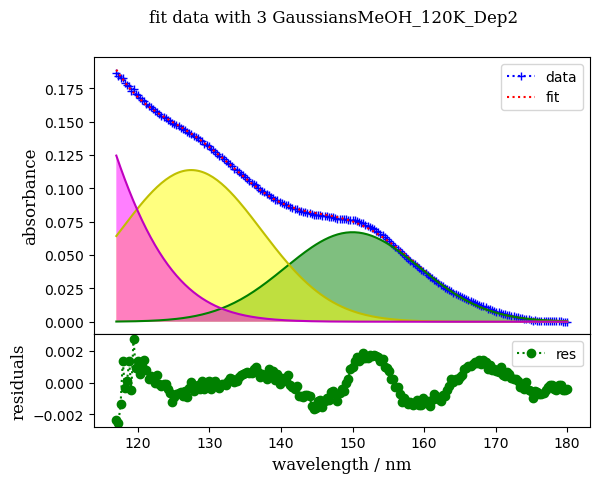

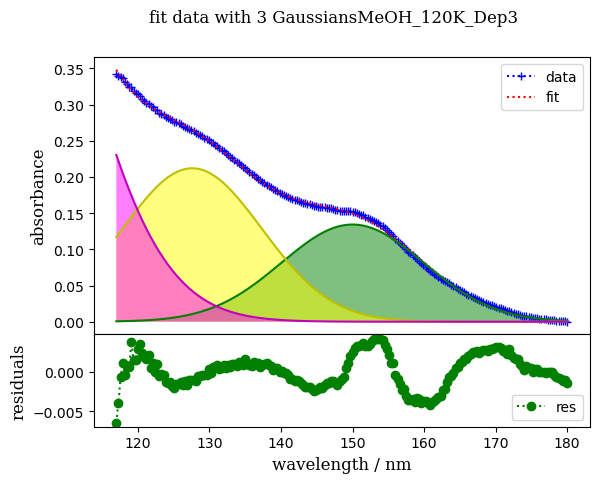

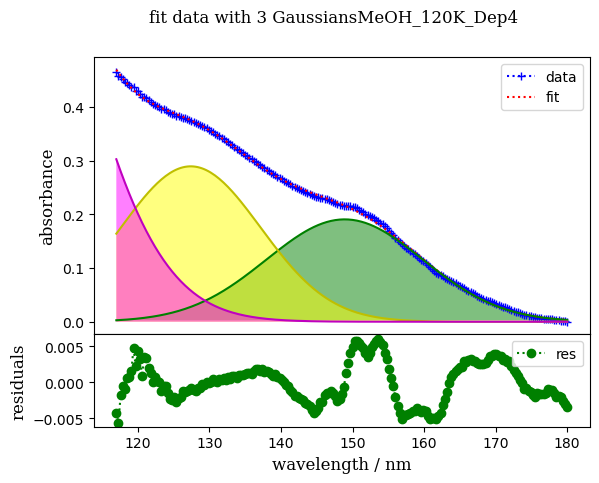

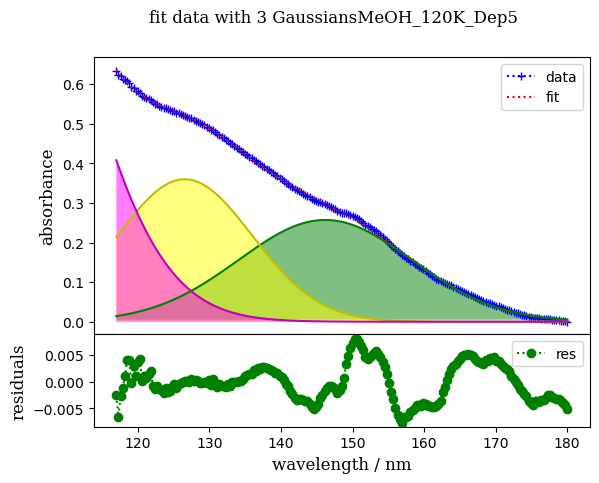

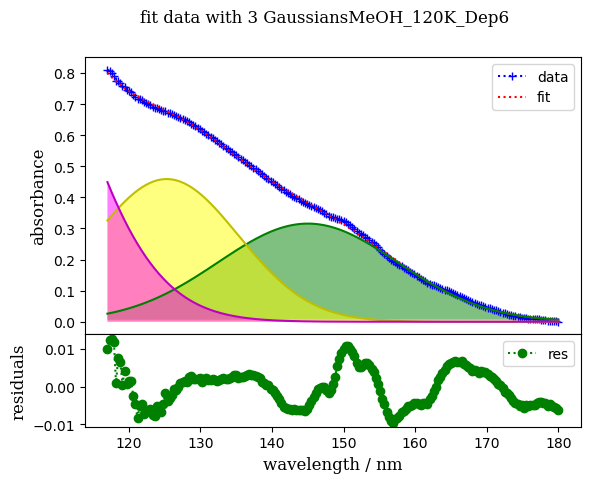

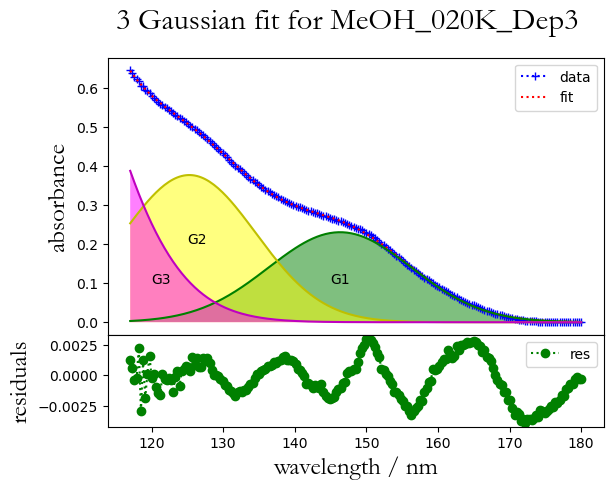

In [2]:
#To convert raw deposition data into normalised absorbance, background substracted, with 3 gaussian fit

#1 - define folder structure
export_path='data/exports'
path = 'data/raw_depositions'

temperatures = listdir(path)
temperatures.sort()
all_temp_mix=temperatures
all_temp = [int(temp[:-1]) for temp in all_temp_mix]  #remove 'K' from the end of each temp and turn into integers


#Use a dictionary to store details on fits for each, this is the data_dict and it will have more levels than the standard Python dictionary
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data_dict = nested_dict(3, int)
    
#find all of the raw data
temperatures = [t for t in temperatures if not t.endswith('.csv')]
#column_names are defined in the .txt file generated during a mesaurement. we care about 'Lambda', 'Keith/nA (which is proportional to tranmitted light)'; 'Beam_current'
column_names = ['Lambda','Keith/nA','Ch1/volts','Ch2/volts','Ch3/volts','Z_Motor','Beam_current','temperature','GC_Pres','Time','UBX_x','UBX_y']

#Start rolling through each data file
for temperatures in temperatures:
    temperature_deposition = join(path, temperatures) #access the folder
    #print(temperature_deposition) #check we are in the right place
    data_files = listdir(temperature_deposition) #get all depositions at this temperature
    data_files.sort()
       
    #Identify the background file at this deposition temperature. The naming convention states that this should be file "0" NOTE this assumes that we average over two scans, add more if required.
    BkGd1 = data_files[0]
    BkGd2 = data_files[1]
    
    #take an average of the two background readings as I0
    average_BkGd =pd.DataFrame()
    Background1 = pd.read_csv(join(temperature_deposition, BkGd1),header=[15],delimiter=r"\s+")
    Background2 = pd.read_csv(join(temperature_deposition, BkGd2),header=[15],delimiter=r"\s+")
    Background1.columns = column_names
    #we normalise the transmitted light to the beam current as fluctuations in beamcurrent change the amount of light transmitted;
    Background1['nor_signal'] = ((180/Background1['Beam_current'])*Background1['Keith/nA'])
    Background2.columns = column_names
    Background2['nor_signal'] = ((180/Background2['Beam_current'])*Background2['Keith/nA'])
    average_BkGd['wavelength'] = (Background1['Lambda'])
    average_BkGd['av_BkGd_signal'] = (Background1['nor_signal']+Background2['nor_signal'])/2
    
    #define some arrays to use for averaging
    i = 0
    count=1
    my_list=[] #this is for checking
    
    current_abs = average_BkGd['av_BkGd_signal']
            
    #move through all of the depositions at this substrate temperature:
    for df in data_files:            
        name=df[:-5]
        deposition=df[-6:-5]     
        #print(df) #check we have the right experiment        
        #For all files that are not background:
        if(int(deposition)>0):
            #print(name)
            #print(deposition)
                                               
            #read the data file            
            raw = pd.read_csv(join(temperature_deposition, df),header=[15],delimiter=r"\s+")
            raw.columns = column_names
            #normalise to the beam current
            raw['nor_signal'] = ((180/raw['Beam_current'])*raw['Keith/nA'])
                       
            #average the absorbance signal over the number of scans (expecting 2) for a given deposition
            if(int(i) == int(deposition)):                             
                count=count+1
                #print('I am averaging over '+str(count)+' scans')
                average_signal = (raw['nor_signal']+nor_signal)/count 
                
                df = pd.DataFrame()
                df['wavelength'] = (average_BkGd['wavelength'])  
                df['absorbance'] = np.log10(average_BkGd['av_BkGd_signal']/average_signal, where= (average_BkGd['av_BkGd_signal']/average_signal) > 0) #making sure not to take a log of -ve numbers
                          
                #remove wavelengths with too low absorbance to measure - decide this is below 117 nm
                index = df.index[df['wavelength'] == 117.0][0]
                df = df.iloc[index:]
                df = df.reset_index(drop=True)
                df = df[df['wavelength'] <= 180] # remove data above 180 nm
            
                # attempt to fit with three Gaussians
                #set a linear background by finding the minimum point on the curve and drawing a linear line here
                linear_BkGd=df['absorbance'].min()
                
                #now substract the background from the data
                df['absorbance_bk'] = df['absorbance'] - linear_BkGd  
                #make shorthand for wavelength
                wl =  df['wavelength']
            
                #define the Gaussians:
                def _1gaussian(wl,amp1,cen1,sigma1):
                    return (amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen1)/sigma1)**2))))
            
                def _2gaussian(wl,amp1,cen1,sigma1,amp2,cen2,sigma2):
                    return (amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen1)/sigma1)**2))) + \
                            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen2)/sigma2)**2))))
           
                def _3gaussian(wl,amp1,cen1,sigma1,amp2,cen2,sigma2, amp3, cen3, sigma3):
                     return (amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen1)/sigma1)**2))) + \
                             amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen2)/sigma2)**2))) + \
                             amp3*(1/(sigma3*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen3)/sigma3)**2))))
            
                #set limits for fitting; amp1,position1, width1,amp2,position2, width2,amp3,position3, width3.
                bounds_min = [0.05,145,0, 0,120,0 ,0,96.5,12.4]
                bounds_max = [100,150,15, 25,130,10, 50,97,12.6]    
                init_vals=[10, 150, 6, 20, 123, 10, 10, 96.8, 12.5] 
            
                #run fit
                popt_3gauss, pcov_3gauss = curve_fit(_3gaussian, wl, df['absorbance_bk'], p0=init_vals, bounds=(bounds_min,bounds_max)
                                        )
                #calculate errors and residuals:
                perr_3gauss = np.sqrt(np.diag(pcov_3gauss)) # calculate the err on the fit
                df['residual_3gauss'] = df['absorbance_bk'] - (_3gaussian(df['wavelength'], *popt_3gauss)) # make a function to subtract the fit from the data called residuals     
                df['_3Gauss_fit'] = _3gaussian(df['wavelength'], *popt_3gauss)
                residuals=sum((df['absorbance_bk']-(_3gaussian(df['wavelength'], *popt_3gauss)))**2)
                
                #extract fit parameters:
                pars_1 = popt_3gauss[0:3] # divide the output parameteres into to arrays, one for the first Gaussian; a 2nd for Gaussian 2; etc
                pars_2 = popt_3gauss[3:6]
                pars_3 = popt_3gauss[6:9]
                                                
                pars_err_1 = perr_3gauss[0:3] # divide the output parameteres into to arrays, one for the first Gaussian; a 2nd for Gaussian 2; etc
                pars_err_2 = perr_3gauss[3:6]
                pars_err_3 = perr_3gauss[6:9]
                
                #Put all fits into the dictionary called 'data_dict', "where Gauss_1/2/3" will be keys
                Gauss_1 = np.concatenate((pars_1, pars_err_1))
                Gauss_2 = np.concatenate((pars_2, pars_err_2))
                Gauss_3 = np.concatenate((pars_3, pars_err_3))
                
                Gaussian_peaks_list = [Gauss_1,Gauss_2,Gauss_3]
                iterate=['Gauss_1','Gauss_2','Gauss_3']
                start=0
                
                for Gauss in iterate:   
                    data_dict[temperatures][deposition][Gauss] +=  (Gaussian_peaks_list[start])
                    start=start+1
                
                #append fits to the df:
                df['gauss_peak_1'] = _1gaussian(df['wavelength'], *pars_1)
                df['gauss_peak_2'] = _1gaussian(df['wavelength'], *pars_2)
                df['gauss_peak_3'] = _1gaussian(df['wavelength'], *pars_3)
                df['residuals_sum'] = residuals
            
                #print(df.head()) #show the dataframe
                       
                #plot each fit, file by file
                fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3,1]}) # I am making a 2 x 1 row x column grid, when the first row is 3 times the height ofthe2nd
                fig.subplots_adjust(hspace=0) # Remove horizontal space between axes
    
                fig.suptitle('fit data with 3 Gaussians'+name, family="serif", fontsize=12)
                plt.xlabel('wavelength / nm', family="serif", fontsize=12)
                axs[1].plot(wl,df['residual_3gauss'],'go:',label='res')
                axs[1].legend() 
                axs[1].set_ylabel("residuals",family="serif", fontsize=12)  
                axs[0].plot(wl,df['absorbance_bk'],'b+:',label='data')
                axs[0].plot(wl,df['_3Gauss_fit'],'r:',label='fit')
                axs[0].legend()
                axs[0].plot(wl, df['gauss_peak_1'], "g")
                axs[0].fill_between(wl, df['gauss_peak_1'].min(), df['gauss_peak_1'], facecolor="green", alpha=0.5)
                axs[0].set_ylabel("absorbance",family="serif", fontsize=12)    
                axs[0].plot(wl, df['gauss_peak_2'], "y")
                axs[0].fill_between(wl, df['gauss_peak_2'].min(), df['gauss_peak_2'], facecolor="yellow", alpha=0.5)  
                axs[0].plot(wl, df['gauss_peak_3'], "m")
                axs[0].fill_between(wl, df['gauss_peak_3'].min(), df['gauss_peak_3'], facecolor="magenta", alpha=0.5)  
                #axs[0].annotate(residuals, xy =(150, max(df['absorbance_bk']))) #we could print the sum of all residuals as an extimate of goodness of fit
                plt.show() #This command would plot a different graph for each f during the cycling
   
                #Save the dataframe to csv file
                os.chdir(export_path)
                df.to_csv(name+'.csv', index=False)
                os.chdir('..')
                os.chdir('..') 
                                       
            else:
                 #see where we are for averaging
                i = deposition
                count=1
                nor_signal = raw['nor_signal'].to_numpy()
                #Make a list to know which deposition we are on:
                my_list.append(i)
                #print(my_list)
                
                


#check that all works OK.
#print(data_dict)
#NOTE data_dict[temperatures][deposition][Gauss][amplitude,position,width,amp_err,position_err,width_err]

#plot example for peak labelling
Temp_to_plot = ('020K') #e.g., 100K (no space!)
Dep_to_plot = ('3') #e.g., '2' just number

File_name = ('MeOH_'+(Temp_to_plot)+'_Dep'+(Dep_to_plot))

os.chdir(export_path)
file_to_plot = pd.read_csv(File_name+'.csv',header=[0])

os.chdir('..')
os.chdir('..')

fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3,1]}) # I am making a 2 x 1 row x column grid, when the first row is 3 times the height ofthe2nd
fig.subplots_adjust(hspace=0) # Remove horizontal space between axes
    
fig.suptitle('3 Gaussian fit for '+File_name, family="garamond", fontsize=22)
plt.xlabel('wavelength / nm', family="garamond", fontsize=18)
axs[1].plot(file_to_plot['wavelength'],file_to_plot['residual_3gauss'],'go:',label='res')
axs[1].legend() 
axs[1].set_ylabel("residuals",family="garamond", fontsize=18)  
axs[0].plot(file_to_plot['wavelength'],file_to_plot['absorbance_bk'],'b+:',label='data')
axs[0].plot(file_to_plot['wavelength'],file_to_plot['_3Gauss_fit'],'r:',label='fit')
axs[0].legend()
axs[0].plot(file_to_plot['wavelength'], file_to_plot['gauss_peak_1'], "g")
axs[0].fill_between(file_to_plot['wavelength'], file_to_plot['gauss_peak_1'].min(), file_to_plot['gauss_peak_1'], facecolor="green", alpha=0.5)
axs[0].set_ylabel("absorbance",family="garamond", fontsize=18)    
axs[0].plot(file_to_plot['wavelength'], file_to_plot['gauss_peak_2'], "y")
axs[0].fill_between(file_to_plot['wavelength'], file_to_plot['gauss_peak_2'].min(), file_to_plot['gauss_peak_2'], facecolor="yellow", alpha=0.5)  
axs[0].plot(file_to_plot['wavelength'], file_to_plot['gauss_peak_3'], "m")
axs[0].fill_between(file_to_plot['wavelength'], file_to_plot['gauss_peak_3'].min(), file_to_plot['gauss_peak_3'], facecolor="magenta", alpha=0.5)  

axs[0].annotate('G1', xy =(145, 0.1))
axs[0].annotate('G2', xy = (125,0.2))
axs[0].annotate('G3', xy = (120, 0.1))
                
plt.show()

            
            

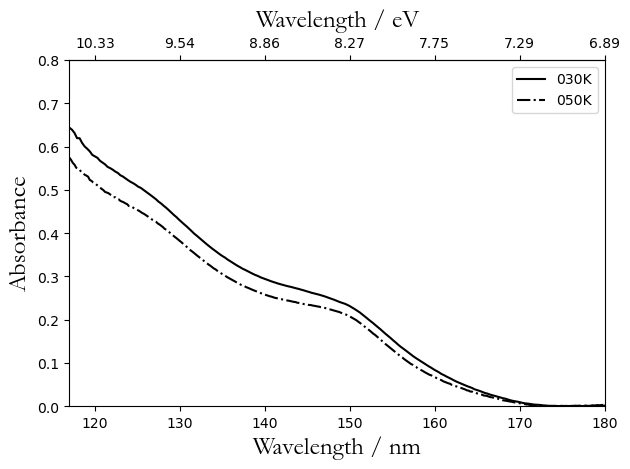

In [3]:
#plot selected spectra
Temp_to_plot = ('030K','050K') #e.g., 100K, 020K  - alwyas three digits (no space!) You can plot two different temperatures
Dep_to_plot = ('3') #e.g., '2' just number

File_name1 = ('MeOH_'+(Temp_to_plot[0])+'_Dep'+(Dep_to_plot))
File_name2 = ('MeOH_'+(Temp_to_plot[1])+'_Dep'+(Dep_to_plot))

os.chdir(export_path)
file1_to_plot = pd.read_csv(File_name1+'.csv',header=[0])#,delimiter=r"\s+")
file2_to_plot = pd.read_csv(File_name2+'.csv',header=[0])#,delimiter=r"\s+")

os.chdir('..')
os.chdir('..')

# Function to prevent zero values in an array
def preventDivisionByZero(some_array):
    corrected_array = some_array.copy()
    for i, entry in enumerate(some_array):
        # If element is zero, set to some small value
        if abs(entry) < float_info.epsilon:
            corrected_array[i] = float_info.epsilon
    
    return corrected_array

# Converting wavelength (nm) to energy (eV)
def WLtoE(wl):
    # Prevent division by zero error
    wl = preventDivisionByZero(wl)

    # E = h*c/wl            
    h = constants.h         # Planck constant
    c = constants.c         # Speed of light
    J_eV = constants.e      # Joule-electronvolt relationship
    
    wl_nm = wl * 10**(-9)   # convert wl from nm to m
    E_J = (h*c) / wl_nm     # energy in units of J
    E_eV = E_J / J_eV       # energy in units of eV
    
    return E_eV  

# Converting energy (eV) to wavelength (nm)
def EtoWL(E):
    # Prevent division by zero error
    E = preventDivisionByZero(E)
    
    # Calculates the wavelength in nm
    return constants.h * constants.c / (constants.e * E) * 10**9

fig, ax1 = plt.subplots()

ax1.plot(file1_to_plot['wavelength'], file1_to_plot['absorbance_bk'],'k-', label=(Temp_to_plot[0]))
ax1.plot(file2_to_plot['wavelength'], file2_to_plot['absorbance_bk'], 'k-.', label=(Temp_to_plot[1]))

ax1.set_ylabel('Absorbance',family="garamond", fontsize=18)
ax1.set_xlabel('Wavelength / nm',family="garamond", fontsize=18)
plt.ylim(0,0.8)
ax1.set_xlim(117,180)

# Create the second x-axis on which the energy in eV will be displayed
ax2 = ax1.secondary_xaxis('top', functions=(WLtoE, EtoWL))
ax2.set_xlabel('Wavelength / eV',family="garamond", fontsize=18, labelpad=7)

# Get ticks from ax1 (wavelengths)
wl_ticks = ax1.get_xticks()
wl_ticks = preventDivisionByZero(wl_ticks)

# Based on the ticks from ax1 (wavelengths), calculate the corresponding energies in eV
E_ticks = WLtoE(wl_ticks)

# Set the ticks for ax2 (Energy)
ax2.set_xticks(E_ticks)

# Allow for two decimal places on ax2 (Energy)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



ax1.legend()
plt.tight_layout()
plt.show()

    



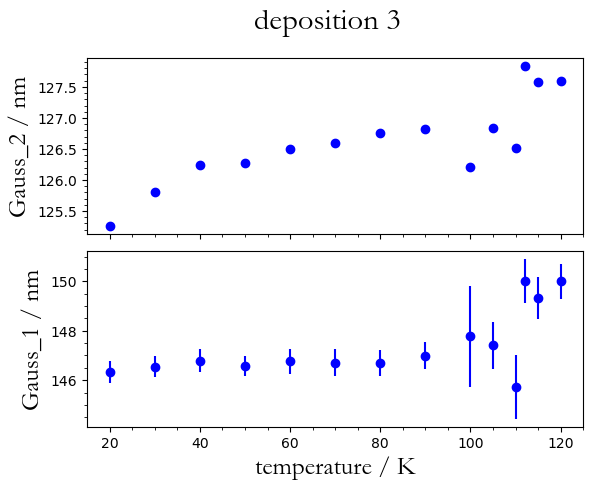

[20, 30, 40, 50, 60, 70, 80, 90, 100, 105, 110, 112, 115, 120]


In [4]:
#choose a deposition to extract and compare peak positions
deposition_to_use=('3')
which_Gauss_top=('Gauss_2')
which_Gauss_bottom=('Gauss_1')


Gauss_top_pos = [data_dict['020K'][deposition_to_use][which_Gauss_top][1],
               data_dict['030K'][deposition_to_use][which_Gauss_top][1],
               data_dict['040K'][deposition_to_use][which_Gauss_top][1],
               data_dict['050K'][deposition_to_use][which_Gauss_top][1],
               data_dict['060K'][deposition_to_use][which_Gauss_top][1],
               data_dict['070K'][deposition_to_use][which_Gauss_top][1],
               data_dict['080K'][deposition_to_use][which_Gauss_top][1],
               data_dict['090K'][deposition_to_use][which_Gauss_top][1],
                data_dict['100K'][deposition_to_use][which_Gauss_top][1],
               data_dict['105K'][deposition_to_use][which_Gauss_top][1],
               data_dict['110K'][deposition_to_use][which_Gauss_top][1],
               data_dict['112K'][deposition_to_use][which_Gauss_top][1],
               data_dict['115K'][deposition_to_use][which_Gauss_top][1],
               data_dict['120K'][deposition_to_use][which_Gauss_top][1]]

Gauss_top_pos_err = [data_dict['020K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['030K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['040K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['050K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['060K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['070K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['080K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['090K'][deposition_to_use][which_Gauss_top][4],
                     data_dict['100K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['105K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['110K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['112K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['115K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['120K'][deposition_to_use][which_Gauss_top][4]]                  

Gauss_bottom_pos = [data_dict['020K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['030K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['040K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['050K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['060K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['070K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['080K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['090K'][deposition_to_use][which_Gauss_bottom][1],
                data_dict['100K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['105K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['110K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['112K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['115K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['120K'][deposition_to_use][which_Gauss_bottom][1]]               

Gauss_bottom_pos_err = [data_dict['020K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['030K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['040K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['050K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['060K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['070K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['080K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['090K'][deposition_to_use][which_Gauss_bottom][4],
                        data_dict['100K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['105K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['110K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['112K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['115K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['120K'][deposition_to_use][which_Gauss_bottom][4]]
                   

fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,1]}) # I am making a 2 x 1 row x column grid
fig.subplots_adjust(hspace=0.1)
plt.xlabel('temperature / K', family="garamond", fontsize=18)
fig.suptitle('deposition '+str(deposition_to_use), family="garamond", fontsize=22)

#ax.errorbar(x, z, markersize=10, xerr=sigx, yerr=sigy, fmt='.', color='red', label='observed')
axs[0].errorbar(all_temp, Gauss_top_pos, yerr=None, xerr = None , fmt='bo', label='Peak 1')

axs[0].set_ylabel(str(which_Gauss_top)+" / nm",family="garamond", fontsize=18)   
axs[0].minorticks_on()

#axs[1].plot(all_temp, Gauss_bottom_pos, 'go', label='Peak 2')
axs[1].errorbar(all_temp, Gauss_bottom_pos, yerr=Gauss_bottom_pos_err, xerr = None , fmt='bo', label='Peak 1')
#axs[1].axhline(y=allPeak2[1], linewidth=0.7, color='k', ls='--')
axs[1].set_ylabel(str(which_Gauss_bottom)+" / nm",family="garamond", fontsize=18)
axs[1].minorticks_on()

plt.show()

#save to text file
print(all_temp)
data = np.column_stack((all_temp, Gauss_top_pos))
np.savetxt("MeOH positions for Gauss2.txt", data, delimiter=' ', header='Temperature(K) PeakPosition(nm)', comments='') 



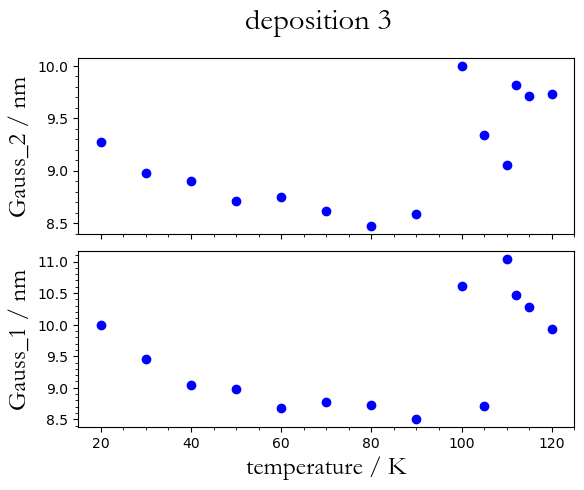

In [12]:
#choose a deposition to extract and compare peak widths
deposition_to_use=('3')
which_Gauss_top=('Gauss_2')
which_Gauss_bottom=('Gauss_1')

Gauss_top_pos = [data_dict['020K'][deposition_to_use][which_Gauss_top][2],
               data_dict['030K'][deposition_to_use][which_Gauss_top][2],
               data_dict['040K'][deposition_to_use][which_Gauss_top][2],
               data_dict['050K'][deposition_to_use][which_Gauss_top][2],
               data_dict['060K'][deposition_to_use][which_Gauss_top][2],
               data_dict['070K'][deposition_to_use][which_Gauss_top][2],
               data_dict['080K'][deposition_to_use][which_Gauss_top][2],
               data_dict['090K'][deposition_to_use][which_Gauss_top][2],
                 data_dict['100K'][deposition_to_use][which_Gauss_top][2],
               data_dict['105K'][deposition_to_use][which_Gauss_top][2],
               data_dict['110K'][deposition_to_use][which_Gauss_top][2],
               data_dict['112K'][deposition_to_use][which_Gauss_top][2],
               data_dict['115K'][deposition_to_use][which_Gauss_top][2],
               data_dict['120K'][deposition_to_use][which_Gauss_top][2]
               ]

Gauss_top_pos_err = [data_dict['020K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['030K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['040K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['050K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['060K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['070K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['080K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['090K'][deposition_to_use][which_Gauss_top][5],
                     data_dict['100K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['105K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['110K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['112K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['115K'][deposition_to_use][which_Gauss_top][5],
                   data_dict['120K'][deposition_to_use][which_Gauss_top][5]
                   ]

Gauss_bottom_pos = [data_dict['020K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['030K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['040K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['050K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['060K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['070K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['080K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['090K'][deposition_to_use][which_Gauss_bottom][2],
                    data_dict['100K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['105K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['110K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['112K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['115K'][deposition_to_use][which_Gauss_bottom][2],
               data_dict['120K'][deposition_to_use][which_Gauss_bottom][2]
               ]

Gauss_bottom_pos_err = [data_dict['020K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['030K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['040K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['050K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['060K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['070K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['080K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['090K'][deposition_to_use][which_Gauss_bottom][5],
                        data_dict['100K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['105K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['110K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['112K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['115K'][deposition_to_use][which_Gauss_bottom][5],
                   data_dict['120K'][deposition_to_use][which_Gauss_bottom][5],
                   ]

fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,1]}) # I am making a 2 x 1 row x column grid
fig.subplots_adjust(hspace=0.1)
plt.xlabel('temperature / K', family="garamond", fontsize=18)
fig.suptitle('deposition '+str(deposition_to_use), family="garamond", fontsize=22)

#ax.errorbar(x, z, markersize=10, xerr=sigx, yerr=sigy, fmt='.', color='red', label='observed')
axs[0].errorbar(all_temp, Gauss_top_pos, yerr=None, xerr = None , fmt='bo', label='Peak 1')

axs[0].set_ylabel(str(which_Gauss_top)+" / nm",family="garamond", fontsize=18)   
axs[0].minorticks_on()

#axs[2].plot(all_temp, Gauss_bottom_pos, 'go', label='Peak 2')
axs[1].errorbar(all_temp, Gauss_bottom_pos, yerr=None, xerr = None , fmt='bo', label='Peak 1')
#axs[2].axhline(y=allPeak2[2], linewidth=0.7, color='k', ls='--')
axs[1].set_ylabel(str(which_Gauss_bottom)+" / nm",family="garamond", fontsize=18)
axs[1].minorticks_on()

plt.show()

#save to text file

data = np.column_stack((all_temp, Gauss_top_pos))
#np.savetxt("MeOH positions for Gauss2.txt", data, delimiter=' ', header='Temperature(K) PeakPosition(nm)', comments='') 


#shortcut to get back to the right directory
print(os.getcwd())
os.chdir('..')
print(os.getcwd())

In [9]:
# to plot peak evolution for all depositions at all temperatures
#make an empty dictionary to store the result
all_abs_peak_positions = {}
all_abs_peak_positions['temps'] = {}
all_abs_peak_positions['peaks'] = {}
#how many temperatures are in data_dict?
num_temp = len(data_dict)
#print('There are ', num_temp ,' temperatures to cycle through')
# Retrieve the keys from the temperature-level in data_dictionary
temperature_entries = list(data_dict.keys())
temperature_entries.sort()

#print(temperature_entries)

for temperature in temperature_entries:  
    
    Gauss_1_pos=[]
    Gauss_1_err=[]
    Gauss_2_pos=[]
    round_Gauss_2_pos=[]
    Gauss_2_err=[]
    peak_absorbances=[]
    deposition_level_keys = []
    
    
    #how many depositions are ar that temperature?
    temperature_entry = data_dict[temperature]
    num_deposition = len(temperature_entry)
    #print('There were ', num_deposition ,' depositions at '+ temperature)
    
    # Retrieve the keys from the deposition-level in data_dictionary
    deposition_level_dict = data_dict[temperature]
    deposition_level_keys.extend(deposition_level_dict.keys())
    #print(deposition_level_keys)

    for deposition in deposition_level_keys: 
        Gauss_1_pos += [data_dict[temperature][deposition]['Gauss_1'][1]]
        Gauss_1_err += [data_dict[temperature][deposition]['Gauss_1'][4]]
        Gauss_2_pos += [data_dict[temperature][deposition]['Gauss_2'][1]]
        round_Gauss_2_pos = [round(number) for number in Gauss_2_pos]
        most_recent_round_Gauss_2_pos = (round_Gauss_2_pos[-1])
        Gauss_2_err += [data_dict[temperature][deposition]['Gauss_2'][4]]
          
        File_name = ('MeOH_'+(temperature)+'_Dep'+(deposition))
        os.chdir(export_path)
        file_to_plot = pd.read_csv(File_name+'.csv',header=[0])#,delimiter=r"\s+")
        os.chdir('..')
        os.chdir('..')
        file_to_plot['round_wavelength'] = [round(number) for number in file_to_plot['wavelength']]    
        peak_absorbance = file_to_plot[file_to_plot['round_wavelength'] == most_recent_round_Gauss_2_pos]['absorbance'].iloc[0]
        peak_absorbances = np.append(peak_absorbances, peak_absorbance)
        #print('For deposition ',deposition,' at ', temperature, ' the peak absorbance for Gauss 2 at ',most_recent_round_Gauss_2_pos,' nm is:\n ',peak_absorbance)
        
    #save to the dictionary
    all_abs_peak_positions[temperature] = (peak_absorbances,Gauss_2_pos) 

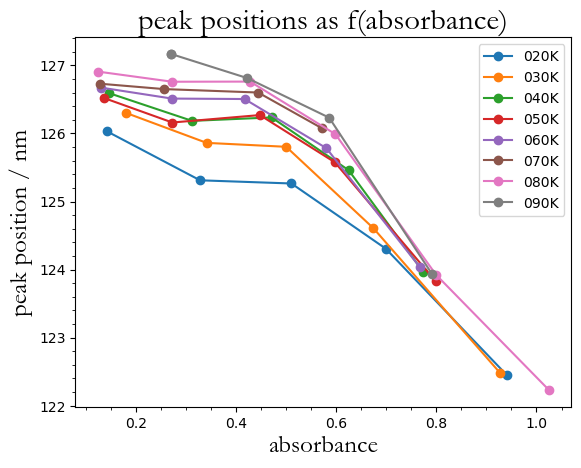

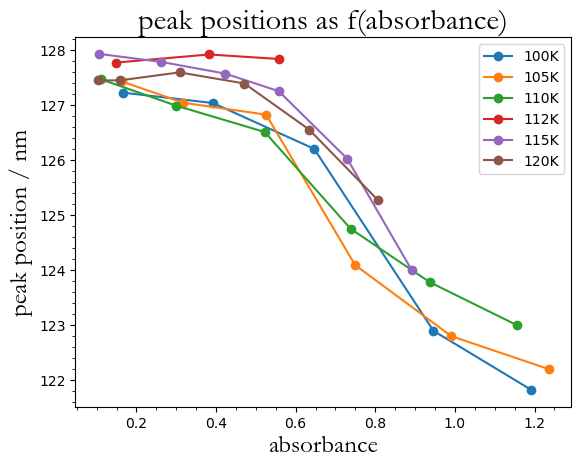

In [10]:
# to plot peak evolution for depositions between 20-90 K
# Retrieve the keys from the temperature-level in data_dictionary
#print(all_abs_peak_positions)
temp_entries = list(all_abs_peak_positions.keys())

spont_temp_entries =temp_entries[2:10]
non_spont_temp_entries =temp_entries[10:]


for temps in spont_temp_entries: 
    plt.plot(all_abs_peak_positions[temps][0],all_abs_peak_positions[temps][1],'-o',label=temps)    
    plt.ylabel('peak position / nm', family="garamond", fontsize=18)   
    plt.xlabel('absorbance', family="garamond", fontsize=18)   
    plt.title('peak positions as f(absorbance)', family="garamond", fontsize=22) 
    plt.legend()
    plt.minorticks_on()
    
plt.show()

for temps in non_spont_temp_entries: 
    plt.plot(all_abs_peak_positions[temps][0],all_abs_peak_positions[temps][1],'-o',label=temps)    
    plt.ylabel('peak position / nm', family="garamond", fontsize=18)   
    plt.xlabel('absorbance', family="garamond", fontsize=18)   
    plt.title('peak positions as f(absorbance)', family="garamond", fontsize=22) 
    plt.legend()
    plt.minorticks_on()



## film thickness from cross section 

Use https://www.aanda.org/articles/aa/pdf/2014/02/aa22140-13.pdf to find the flim thicknesses from their cross sections:


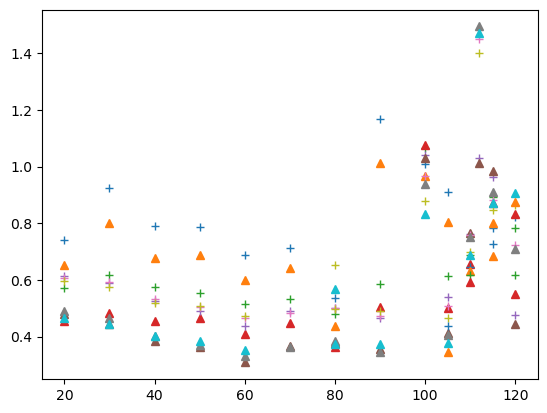

{20: {5: (array([0.59733257]), array([0.46593672]))}, 30: {5: (array([0.57554528]), array([0.44253463]))}, 40: {5: (array([0.5174436]), array([0.40141903]))}, 50: {5: (array([0.50793306]), array([0.38337087]))}, 60: {5: (array([0.472599]), array([0.35115878]))}, 70: {4: (array([0.48372876]), array([0.36427228]))}, 80: {6: (array([0.49648508]), array([0.37267412]))}, 90: {5: (array([0.49152902]), array([0.37228118]))}, 100: {5: (array([0.87783874]), array([0.83405363]))}, 105: {6: (array([0.4373945]), array([0.34477639]))}, 110: {6: (array([0.61595945]), array([0.59354066]))}, 112: {3: (array([1.40262236]), array([1.47003887]))}, 115: {6: (array([0.78255398]), array([0.80151085]))}, 120: {6: (array([0.7841068]), array([0.83255781]))}}


In [34]:
#sigma_121nm  = 8.6e-18 #stop using this becuase it saturates too often in spectra
sigma_157nm = 3.8e-18
sigma_161nm = 2.9e-18

all_dosing_rate = {}
#all_dosing_rate['temps'] = {}
#all_dosing_rate['deposition'] = {}

mol_density = 1.1885597757733392e28 #mol / m3
all_depositions = listdir(export_path)
one_deposition = 15 #s - each deposition was 15 s long
#print(all_depositions)
column_names = ['wavelength','absorbance','absorbance_bk','residual_3gauss','_3Gauss_fit','gauss_peak_1','gauss_peak_2','gauss_peak_3','residuals_sum']
for dep in all_depositions:
       
    Temperature = int(dep[5:8])
    all_dosing_rate[Temperature] = {}
    Deposition = int(dep[-5:-4])
    all_dosing_rate[Temperature][Deposition] = {}
    
    df = pd.read_csv(join(export_path, dep),header=[0])
    df.columns = column_names
    
    #result_121nm = df.loc[df['wavelength'] == 121.2, 'absorbance'].values
    
    #if result_121nm < 0.6:
    #    N_121nm = result_121nm / sigma_121nm
    #    thickness_cm_121nm = N_121nm / (mol_density/1e6)
    #    thickness_121nm = thickness_cm_121nm*1e7
        #print('\nAt ', Temperature, ' and after ', Deposition, ' depositions, the film was ',thickness_121nm, ' nm thick - 121nm')
    #    dose_rate_121nm= thickness_121nm/(Deposition*one_deposition)
    #    plt.plot(Temperature,dose_rate_121nm,'o', label = '121 nm')
    #else:
    #    print('\nAt ', Temperature, ' K and after ', Deposition, ' absorbance is too high at 121 nm')
              
    result_157nm = df.loc[df['wavelength'] == 157.2, 'absorbance'].values
    
    N_157nm = result_157nm / sigma_157nm
    thickness_cm_157nm = N_157nm / (mol_density/1e6)
    thickness_157nm = thickness_cm_157nm*1e7
    #print('\nAt ', Temperature, ' and after ', Deposition, ' depositions, the film was ',thickness_157nm, ' nm thick - 157nm')
    dose_rate_157nm= thickness_157nm/(Deposition*one_deposition)
    plt.plot(Temperature,dose_rate_157nm,'+', label = '157 nm')
    
    
    result_161nm = df.loc[df['wavelength'] == 161.4, 'absorbance'].values
    
    N_161nm = result_161nm / sigma_161nm
    thickness_cm_161nm = N_161nm / (mol_density/1e6)
    thickness_161nm = thickness_cm_161nm*1e7
    #print('\nAt ', Temperature, ' and after ', Deposition, ' depositions, the film was ',thickness_161nm, ' nm thick - 161nm')
    dose_rate_161nm= thickness_161nm/(Deposition*one_deposition)
    plt.plot(Temperature,dose_rate_161nm,'^', label = '161 nm')
    
    all_dosing_rate[Temperature][Deposition] = (dose_rate_157nm,dose_rate_161nm )
    
plt.show()

print(all_dosing_rate)

    